# Final Project, DM Task 4

In our proposal we stated that we will pick the best model, but what if we combine our models to create an Ensemble Model. Being that this is a classification problem we can do this in two ways: VotingClassifier (soft or hard) or StackingClassifier.


### VotingClassifier

The hard voting method will take the majority vote and use that for the final prediction. This is also called a majority ensemble or a plurality ensemble.

The advantage of majority voting is that it reduces the error rate of the predictions, meaning that they are more likely to be correct. The disadvantage is that it does not account for the confidence or probability of each prediction, meaning that it can ignore some useful information.

We can also change it to use soft voting and it will consider the probability scores of each class predicted by individual models and averages them but it is harder to implement


### StackingClassifier

Another way to combine multiple models is to use them as inputs for another model. For example, if you have three models that predict the temperature as 15°C, 18°C, and 20°C, you can use their predictions as features for a fourth model that learns how to weigh them and make a final prediction. This is also called a meta-learner or a second-level learner.

The advantage of stacking is that it can learn from the strengths and weaknesses of each model and make a more accurate prediction. The disadvantage is that it can be more complex and prone to overfitting, meaning that it can perform well on the training data but poorly on new data.

## Imported Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import dump #used to save the model
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score

## Helper Function

In [2]:
def eval_model(model, train_data, train_labels, test_data, test_labels, folds):
  """
  Evaluate the model for overfitting and performance using accuracy for both train
  and test. Outputs accuracy, classification report, and confusion matrix

  INPUTS
  ------
  model: the model to test
  train_data: the data to train the model with
  train_labels: the training labels
  test_data: the data to test with (this can also be validation data)
  test_labels: the labels to test with (this can also be validation labels)
  fold: the number of fold to use for training
  """

  # Fit the model
  model.fit(train_data, train_labels)

  # Predict the labels for test
  test_pred = model.predict(test_data)

  # Calculate the accuracy of the model
  train_accuracy = np.mean(cross_val_score(model, train_data, train_labels, cv=folds, scoring='accuracy')) #use cross fold validation
  test_accuracy = accuracy_score(test_labels, test_pred)
  print("Train Accuracy: ", train_accuracy)
  print("Test/Validation Accuracy: ", test_accuracy)

  #create cm
  print(classification_report(test_labels, test_pred))

  #Create and visualize Confusion Matrix for model predictions of the test data
  test_cm = confusion_matrix(test_labels, test_pred)
  plt.matshow(test_cm)
  plt.title('Test Data Confusion Matrix')
  plt.colorbar()
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

  return

## Preprocess

In [4]:
smoker_df = pd.read_csv("data/kaggle_smoker_dataset.csv")

# if cell is ran twice it will fail - try excepts handles that error
try:
    labels_df = smoker_df["smoking"]
    smoker_df.drop(["smoking"], axis=1, inplace=True)
except KeyError as e:
    pass

label_names = ["non-smoker", "smoker"] # 0 = non-smoker and 1 = smoker

# Min-Max scaling
min_max_scaler = MinMaxScaler()
smoker_df_scaled = min_max_scaler.fit_transform(smoker_df)

#train/validation/test split
train_df, test_df, train_labels_df, test_labels_df = train_test_split(smoker_df_scaled, labels_df, test_size=0.2, random_state=33, stratify=labels_df)
train_df, valid_df, train_labels_df, valid_labels_df = train_test_split(train_df, train_labels_df, test_size=0.2, random_state=33, stratify=train_labels_df)

## Define Best Models

look at our individual model notebooks on how we arrived to these models and their hyper params

In [6]:
rbf_svm = SVC(kernel='rbf', C=10, gamma='scale')
knn = KNeighborsClassifier(n_neighbors=82, weights='distance')
xgb = XGBClassifier(colsample_bytree=0.8,gamma=0,learning_rate=0.1,max_depth=5, min_child_weight=1,n_estimators=1000,reg_alpha=0,reg_lambda=0,subsample=0.9)

## Voting Classifier with Hard voting

Train Accuracy:  0.7765038194247786
Test/Validation Accuracy:  0.7869509458159667
              precision    recall  f1-score   support

           0       0.83      0.84      0.83      3947
           1       0.71      0.70      0.71      2291

    accuracy                           0.79      6238
   macro avg       0.77      0.77      0.77      6238
weighted avg       0.79      0.79      0.79      6238



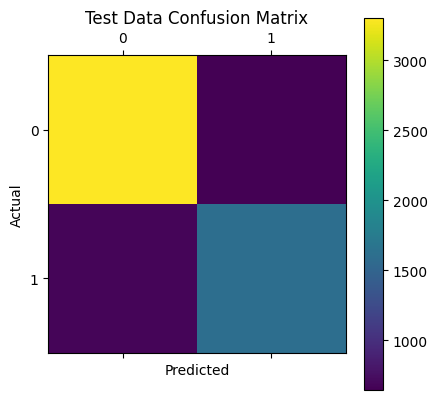

In [7]:
# Combine the models using majority voting
ensemble_hardvoting = VotingClassifier(estimators=[('rbf_svm', rbf_svm), ('knn', knn), ('xgb', xgb)], voting='hard')

#eval model with validation data
eval_model(ensemble_hardvoting, train_df, train_labels_df, valid_df, valid_labels_df, 5)

No signals of overfitting and it did better than all of our individual models

## Voting Classifier with Soft voting

Train Accuracy:  0.7833577276822636
Test/Validation Accuracy:  0.7962487976915678
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      3947
           1       0.73      0.70      0.72      2291

    accuracy                           0.80      6238
   macro avg       0.78      0.78      0.78      6238
weighted avg       0.79      0.80      0.80      6238



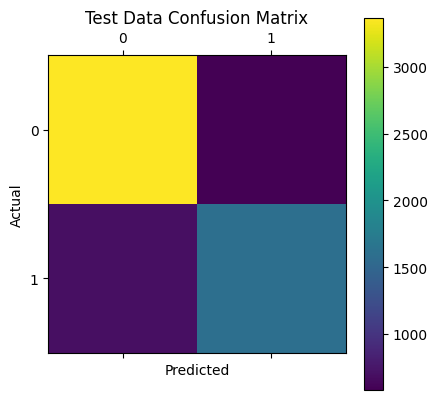

In [8]:
# to use soft voting we have to enable probability estimates
rbf_svm_prob = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
knn_prob = KNeighborsClassifier(n_neighbors=85, weights='distance')
  # for xgb to use probability estimates we have to set objective to binary:logistic and set use_label_encoder=False to false
xgb_prob = XGBClassifier(colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=1,
                     n_estimators=1000, reg_alpha=0, reg_lambda=0, subsample=0.9, objective='binary:logistic', use_label_encoder=False)

# Combine the models using majority voting
ensemble_softvoting = VotingClassifier(estimators=[('rbf_svm', rbf_svm_prob), ('knn', knn_prob), ('xgb', xgb_prob)], voting='soft')

#eval model with validation data
eval_model(ensemble_softvoting, train_df, train_labels_df, valid_df, valid_labels_df, 5)

No signals of overfitting and it did better than all of our individual models

## Stacking Classifier with Logistic Regression as Second-level Learner

More work can be done to find a better second level learner and fine tune it

Train Accuracy:  0.7786681802169181
Test/Validation Accuracy:  0.7943251042000641
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      3947
           1       0.73      0.71      0.72      2291

    accuracy                           0.79      6238
   macro avg       0.78      0.78      0.78      6238
weighted avg       0.79      0.79      0.79      6238



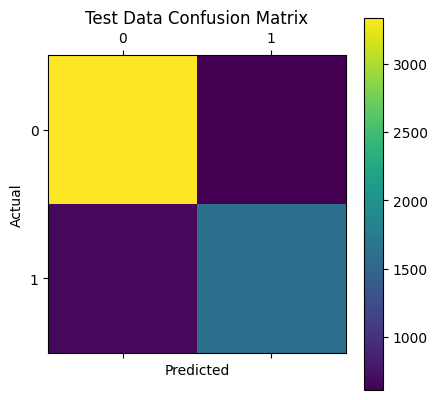

In [9]:
#define second-level learner
log_reg = LogisticRegression(penalty='l2')

# Create a stacking ensemble
ensemble_stack = StackingClassifier(estimators=[('rbf_svm', rbf_svm), ('knn', knn), ('xgb', xgb)], final_estimator=log_reg)

#eval model with validation data
eval_model(ensemble_stack, train_df, train_labels_df, valid_df, valid_labels_df, 5)

## Using the Best Model to eval on Test split

Train Accuracy:  0.7832775512942101
Test/Validation Accuracy:  0.7885084006669232
              precision    recall  f1-score   support

           0       0.83      0.84      0.83      4933
           1       0.72      0.69      0.71      2864

    accuracy                           0.79      7797
   macro avg       0.77      0.77      0.77      7797
weighted avg       0.79      0.79      0.79      7797



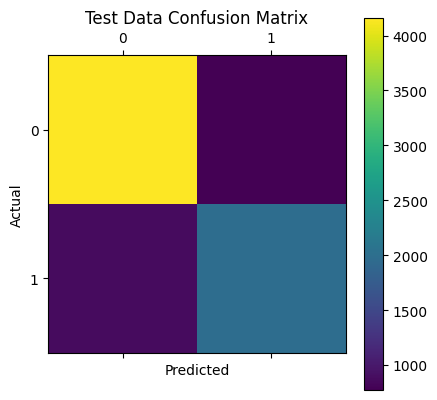

In [10]:
#eval model with test data
eval_model(ensemble_softvoting, train_df, train_labels_df, test_df, test_labels_df, 5)

## Save The Best Model

We will be using our best model in our app, so we need to save the model and the scaler. Doing this will avoid having to re train the model and fit the scaler.

In [11]:
# Save the scaler to disk
dump(min_max_scaler, 'min_max_scaler.joblib')
# Save the model to disk
dump(ensemble_softvoting, 'ensemble_softvoting_model.joblib')

['ensemble_softvoting_model.joblib']